# Sandbox for playing around with heading-based segmentation, etc.

From Katy, with cosmetic tweaks by Emilio

In [39]:
import movingpandas as mpd
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import Point
import pandas as pd
import numpy as np
import hvplot.pandas
import holoviews as hv
import seaborn as sns

In [40]:
mpd.__version__

'0.2.rc2'

### Loading in dataset

In [41]:
file = 'ooinhdeep_points.geojson'
gdf = gpd.read_file(file)
gdf.head()

id       datetime_start         datetime_end direction  \
0  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
1  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
2  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
3  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
4  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   

   dive_nbr_start  dive_nbr_end glider_id deployment_id  \
0             759           827     ce383   ce383_Feb20   
1             759           827     ce383   ce383_Feb20   
2             759           827     ce383   ce383_Feb20   
3             759           827     ce383   ce383_Feb20   
4             759           827     ce383   ce383_Feb20   

                                            data_url  longitude  latitude  \
0  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.30895  44.65061   
1  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.30634  44.65065   
2  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.31882  44.64663   
3  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.32215  44.64606   
4  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.32525  44.64547   

                      geometry  
0  POINT (-124.30895 44.65061)  
1  POINT (-124.30634 44.65065)  
2  POINT (-124.31882 44.64663)  
3  POINT (-124.32215 44.64606)  
4  POINT (-124.32525 44.64547)

In [42]:
gdf.hvplot()

:Points   [x,y]

### Define functions to generate rule-based trajectories

In [43]:
#Shifting dataframes to apply bearing calculation. This accounts for the fact that 
#https://gist.github.com/jeromer/2005586
def bearing(gdf):
    from numpy import sin, cos, arctan2
    #Take difference between i and i+1 rows, we get a deltalon column
    deltalon = np.deg2rad(gdf['longitude'].diff(1).shift(-1))
    #Move i+1 to ith row, now we have our lat2 column
    lat2 = np.deg2rad(gdf.shift(-1)['latitude'])
    #Keep rows the same, this is our lat1 column
    lat1 = np.deg2rad(gdf['latitude'])

    x0 = sin(deltalon)*cos(lat2)
    x1 = cos(lat1)*sin(lat2) - sin(lat1)*cos(lat2)*cos(deltalon)
    bearing = arctan2(x0, x1)
    return bearing

def iterative_segmentation(gdf, criterion, tol):
    """
    gdf is the GeoDataFrame with tracks that you're interested in
    criterion is a column name in the gdf that you're using to segment — for example, angle if you're looking
        at changes in heading, or speed
    tol is the tolerance to a given criterion. For example, a tolerance of .3 means that a change of .3
        in criterion value between two rows will be allowed
    """
    if criterion == 'bearing':  #Dealing with unit-circle angle repeats.(Range of arctan2 function is from -pi to pi)
        angle_adj = lambda a: (a + np.pi)%(2*np.pi) - np.pi
        tol_func = lambda a, b: abs(angle_adj(a - b))
    else:
        tol_func = lambda a, b: abs(a - b)
    trajectory_id = []
    j = 0 #First trajectory id
    k = 0 #0 represents first value in a trajectory, 1 is any value after that
    for i, row in gdf.iterrows():
        trajectory_id.append(j)
        if k == 0: #First row, do nothing
            k = 1
        else:
            if tol_func(start_value, row[criterion]) < tol:
                pass
            elif tol_func(start_value, row[criterion]) >= tol:
                j+=1 #Start a new trajectory label
                k = 0
        start_value = row[criterion] #Update comparison value. This method is more robust to changes in curvature
        #that may not represent a new trajectory
    gdf['traj_id'] = trajectory_id
    return gdf

def absolute_segmentation(gdf, criterion, tol):
    """
    gdf is the GeoDataFrame with tracks that you're interested in
    criterion is a column name in the gdf that you're using to segment — for example, angle if you're looking
        at changes in heading, or speed
    tol is the tolerance to a given criterion. For example, a tolerance of .3 means that a change of .3
        in criterion value between two rows will be allowed
    """
    trajectory_id = []
    if criterion == 'bearing':  #Dealing with unit-circle angle repeats.(Range of arctan2 function is from -pi to pi)
        angle_adj = lambda a: (a + np.pi)%(2*np.pi) - np.pi
        tol_func = lambda a, b: abs(angle_adj(a - b))
    else:
        tol_func = lambda a, b: abs(a - b)
    j = 0 #i.e., the first trajectory
    k = 0 #0 represents first value in a trajectory, 1 is any value after that
    for i, row in gdf.iterrows():
        trajectory_id.append(j)
        #Assign starting value for the criterion
        if k == 0:
            start_value = row[criterion]
            k = 1
        else:
            if tol_func(start_value, row[criterion]) < tol:
                pass
            elif tol_func(start_value, row[criterion]) >= tol:
                j+=1 #Start a new trajectory label
                k = 0
         #Update 
    gdf['traj_id'] = trajectory_id
    return gdf

### Calculate direction of tracks from lat, lon and segment into trajectories

In [44]:
gdf['bearing'] = bearing(gdf)

##### Iterative segmentation

In [45]:
#Looking at output of iterative_segmentation with a tolerance of 45 degrees
seg_gdf = iterative_segmentation(gdf, 'bearing', np.pi/4)
print(f"Number of individual trajectories is {np.max(seg_gdf['traj_id'])}")

Number of individual trajectories is 196


In [46]:
seg_gdf.head()

id       datetime_start         datetime_end direction  \
0  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
1  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
2  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
3  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
4  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   

   dive_nbr_start  dive_nbr_end glider_id deployment_id  \
0             759           827     ce383   ce383_Feb20   
1             759           827     ce383   ce383_Feb20   
2             759           827     ce383   ce383_Feb20   
3             759           827     ce383   ce383_Feb20   
4             759           827     ce383   ce383_Feb20   

                                            data_url  longitude  latitude  \
0  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.30895  44.65061   
1  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.30634  44.65065   
2  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.31882  44.64663   
3  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.32215  44.64606   
4  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.32525  44.64547   

                      geometry   bearing  traj_id  
0  POINT (-124.30895 44.65061)  1.549241        0  
1  POINT (-124.30634 44.65065) -1.995876        0  
2  POINT (-124.31882 44.64663) -1.806881        1  
3  POINT (-124.32215 44.64606) -1.832165        1  
4  POINT (-124.32525 44.64547) -1.830912        1

(-128.19414, -123.97586, 44.4746975, 44.7416125)

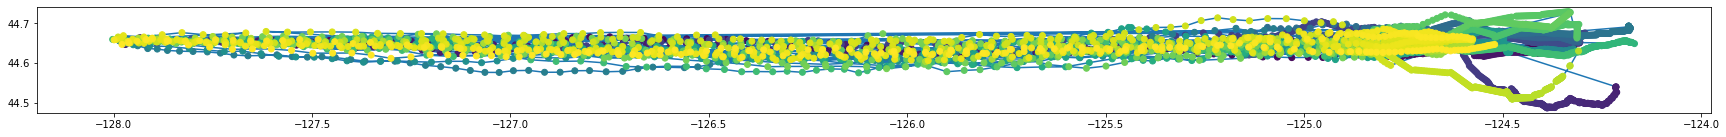

In [47]:
#Plot all output on scaled axis, to get a better sense of "true" angles
plt.figure(figsize = (30,5))
plt.plot(seg_gdf['longitude'], seg_gdf['latitude'], zorder = 0)
plt.scatter(seg_gdf['longitude'], seg_gdf['latitude'], c = seg_gdf['traj_id'])
plt.axis('scaled')

In [49]:
traj_collection = mpd.TrajectoryCollection(seg_gdf, 'traj_id')
plot = traj_collection.hvplot()
hvplot.save(plot, 'gliders.html')
plot

:Overlay
   .Tiles.I        :Tiles   [x,y]
   .Path.I         :Path   [Longitude,Latitude]
   .Path.II        :Path   [Longitude,Latitude]
   .Path.III       :Path   [Longitude,Latitude]
   .Path.IV        :Path   [Longitude,Latitude]
   .Path.V         :Path   [Longitude,Latitude]
   .Path.VI        :Path   [Longitude,Latitude]
   .Path.VII       :Path   [Longitude,Latitude]
   .Path.VIII      :Path   [Longitude,Latitude]
   .Path.IX        :Path   [Longitude,Latitude]
   .Path.X         :Path   [Longitude,Latitude]
   .Path.XI        :Path   [Longitude,Latitude]
   .Path.XII       :Path   [Longitude,Latitude]
   .Path.XIII      :Path   [Longitude,Latitude]
   .Path.XIV       :Path   [Longitude,Latitude]
   .Path.XV        :Path   [Longitude,Latitude]
   .Path.XVI       :Path   [Longitude,Latitude]
   .Path.XVII      :Path   [Longitude,Latitude]
   .Path.XVIII     :Path   [Longitude,Latitude]
   .Path.XIX       :Path   [Longitude,Latitude]
   .Path.XX        :Path   [Longitude,Latitude]
   .Path.XXI       :Path   [Longitude,Latitude]
   .Path.XXII      :Path   [Longitude,Latitude]
   .Path.XXIII     :Path   [Longitude,Latitude]
   .Path.XXIV      :Path   [Longitude,Latitude]
   .Path.XXV       :Path   [Longitude,Latitude]
   .Path.XXVI      :Path   [Longitude,Latitude]
   .Path.XXVII     :Path   [Longitude,Latitude]
   .Path.XXVIII    :Path   [Longitude,Latitude]
   .Path.XXIX      :Path   [Longitude,Latitude]
   .Path.XXX       :Path   [Longitude,Latitude]
   .Path.XXXI      :Path   [Longitude,Latitude]
   .Path.XXXII     :Path   [Longitude,Latitude]
   .Path.XXXIII    :Path   [Longitude,Latitude]
   .Path.XXXIV     :Path   [Longitude,Latitude]
   .Path.XXXV      :Path   [Longitude,Latitude]
   .Path.XXXVI     :Path   [Longitude,Latitude]
   .Path.XXXVII    :Path   [Longitude,Latitude]
   .Path.XXXVIII   :Path   [Longitude,Latitude]
   .Path.XXXIX     :Path   [Longitude,Latitude]
   .Path.XL        :Path   [Longitude,Latitude]
   .Path.XLI       :Path   [Longitude,Latitude]
   .Path.XLII      :Path   [Longitude,Latitude]
   .Path.XLIII     :Path   [Longitude,Latitude]
   .Path.XLIV      :Path   [Longitude,Latitude]
   .Path.XLV       :Path   [Longitude,Latitude]
   .Path.XLVI      :Path   [Longitude,Latitude]
   .Path.XLVII     :Path   [Longitude,Latitude]
   .Path.XLVIII    :Path   [Longitude,Latitude]
   .Path.XLIX      :Path   [Longitude,Latitude]
   .Path.L         :Path   [Longitude,Latitude]
   .Path.LI        :Path   [Longitude,Latitude]
   .Path.LII       :Path   [Longitude,Latitude]
   .Path.LIII      :Path   [Longitude,Latitude]
   .Path.LIV       :Path   [Longitude,Latitude]
   .Path.LV        :Path   [Longitude,Latitude]
   .Path.LVI       :Path   [Longitude,Latitude]
   .Path.LVII      :Path   [Longitude,Latitude]
   .Path.LVIII     :Path   [Longitude,Latitude]
   .Path.LIX       :Path   [Longitude,Latitude]
   .Path.LX        :Path   [Longitude,Latitude]
   .Path.LXI       :Path   [Longitude,Latitude]
   .Path.LXII      :Path   [Longitude,Latitude]
   .Path.LXIII     :Path   [Longitude,Latitude]
   .Path.LXIV      :Path   [Longitude,Latitude]
   .Path.LXV       :Path   [Longitude,Latitude]
   .Path.LXVI      :Path   [Longitude,Latitude]
   .Path.LXVII     :Path   [Longitude,Latitude]
   .Path.LXVIII    :Path   [Longitude,Latitude]
   .Path.LXIX      :Path   [Longitude,Latitude]
   .Path.LXX       :Path   [Longitude,Latitude]
   .Path.LXXI      :Path   [Longitude,Latitude]
   .Path.LXXII     :Path   [Longitude,Latitude]
   .Path.LXXIII    :Path   [Longitude,Latitude]
   .Path.LXXIV     :Path   [Longitude,Latitude]
   .Path.LXXV      :Path   [Longitude,Latitude]
   .Path.LXXVI     :Path   [Longitude,Latitude]
   .Path.LXXVII    :Path   [Longitude,Latitude]
   .Path.LXXVIII   :Path   [Longitude,Latitude]
   .Path.LXXIX     :Path   [Longitude,Latitude]
   .Path.LXXX      :Path   [Longitude,Latitude]
   .Path.LXXXI     :Path   [Longitude,Latitude]
   .Path.LXXXII    :Path   [Longitude,Latitude]
   .Path.LXXXIII   :P

##### Absolute-angle segmentation

In [12]:
#Only difference between the two is that absolute_segmentation constrains all trajectories based on the starting
#angle of the trajectory, while iterative_segmentation updates the angle every time a point is added. The former
#may be better for straight-line trajectories, and the latter is probably better if curving/sinuous trajectories
#are present
seg_gdf1 = absolute_segmentation(gdf, 'bearing', .5)
print(f"Number of individual trajectories is {np.max(seg_gdf['traj_id'])}")

Number of individual trajectories is 345


In [13]:
traj_collection1 = mpd.TrajectoryCollection(seg_gdf1, 'traj_id')
traj_collection.hvplot()

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Path.I     :Path   [Longitude,Latitude]
   .Path.II    :Path   [Longitude,Latitude]
   .Path.III   :Path   [Longitude,Latitude]
   .Path.IV    :Path   [Longitude,Latitude]
   .Path.V     :Path   [Longitude,Latitude]
   .Path.VI    :Path   [Longitude,Latitude]
   .Path.VII   :Path   [Longitude,Latitude]
   .Path.VIII  :Path   [Longitude,Latitude]
   .Path.IX    :Path   [Longitude,Latitude]
   .Path.X     :Path   [Longitude,Latitude]
   .Path.XI    :Path   [Longitude,Latitude]
   .Path.XII   :Path   [Longitude,Latitude]
   .Path.XIII  :Path   [Longitude,Latitude]
   .Path.XIV   :Path   [Longitude,Latitude]
   .Path.XV    :Path   [Longitude,Latitude]
   .Path.XVI   :Path   [Longitude,Latitude]
   .Path.XVII  :Path   [Longitude,Latitude]
   .Path.XVIII :Path   [Longitude,Latitude]
   .Path.XIX   :Path   [Longitude,Latitude]
   .Path.XX    :Path   [Longitude,Latitude]
   .Path.XXI   :Path   [Longitude,Latitude]
   .Path.XXII  :Path   [Longitude,Latitude]
   .Path.XXIII :Path   [Longitude,Latitude]

In [14]:
#For comparison with original gdf
gdf['traj_id'] = 1
traj_coll_orig = mpd.TrajectoryCollection(gdf, 'traj_id')

In [15]:
len(traj_collection), type(traj_collection)

(23, movingpandas.trajectory_collection.TrajectoryCollection)

In [16]:
type(traj_collection.trajectories[1])

movingpandas.trajectory.Trajectory

## Comparison with original tracks

In [17]:
trajcoll_0 = traj_collection.trajectories[0].df.drop('geometry', axis=1)

In [18]:
trajcoll_0.head()

id       datetime_start         datetime_end direction  \
0  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   
1  ce383_Feb20_s005  2020-04-07T21:27:06  2020-04-08T21:38:01  Westward   

   dive_nbr_start  dive_nbr_end glider_id deployment_id  \
0             759           827     ce383   ce383_Feb20   
1             759           827     ce383   ce383_Feb20   

                                            data_url  longitude  latitude  \
0  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.30895  44.65061   
1  https://gliders.ioos.us/erddap/tabledap/ce_383... -124.30634  44.65065   

    bearing  traj_id  
0  1.549241        0  
1 -1.995876        0

In [19]:
trajcoll_0.hvplot.line(x='longitude', y='latitude') * trajcoll_0.hvplot.scatter(x='longitude', y='latitude')

:Overlay
   .Curve.I   :Curve   [longitude]   (latitude)
   .Scatter.I :Scatter   [longitude]   (latitude)

In [20]:
trajcoll_orig_0 = traj_coll_orig.trajectories[0].df.drop('geometry', axis=1)

In [21]:
trajcoll_orig_0.head(200).hvplot(x='longitude', y='latitude')

:Curve   [longitude]   (latitude)

### Testing with Northeast U.S. Shelf LTER data

In [22]:
df = pd.read_csv('en649_underway.csv')

In [23]:
df = df[['date', 'gps_furuno_latitude', 'gps_furuno_longitude', 'gps_furuno_quality']]

In [24]:
df = df.rename({'gps_furuno_latitude': 'latitude', 'gps_furuno_longitude': 'longitude'}, axis = 1)

In [25]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

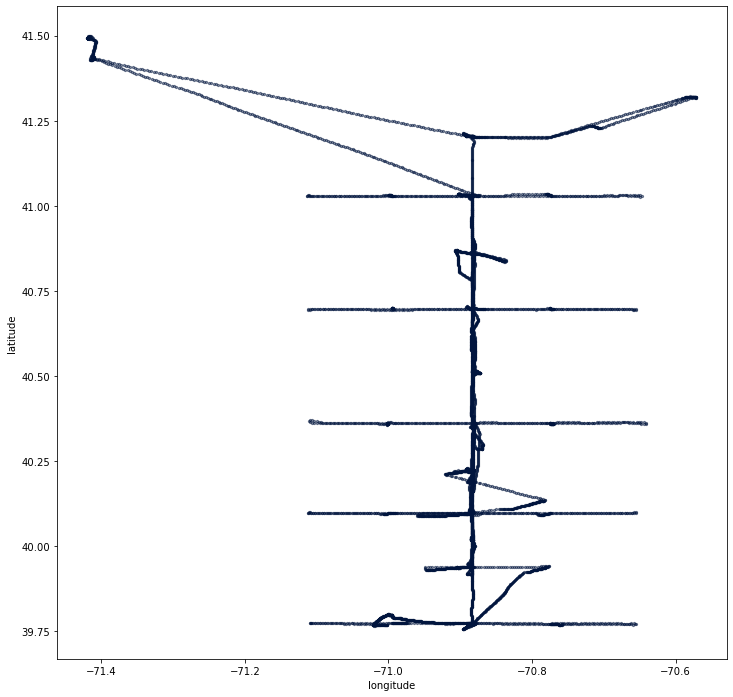

In [26]:
# Plot ship tracks
fig, ax = plt.subplots(figsize = (12,12))
df.plot.scatter('longitude', 'latitude', c='xkcd:navy', s=5, alpha=0.5, ax=ax)

Text(0.5, 1.0, 'Segments')

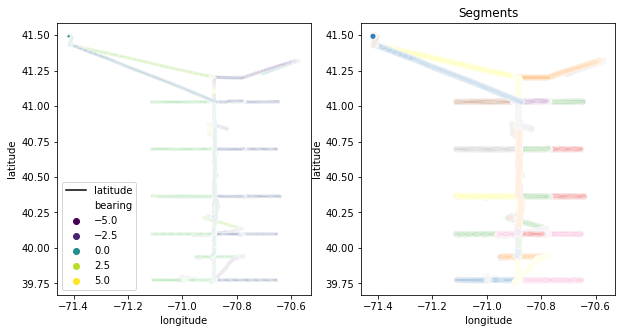

In [27]:
# Apply segmentation
gdf['bearing'] = bearing(gdf)
gdf = iterative_segmentation(gdf, 'bearing', np.deg2rad(45))
gdf['traj_id'] = gdf['traj_id'].astype('category')  # improves plotting with Seaborn

# Plot bearing and segmentation
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
for ax in axs:
    ax.plot('longitude', 'latitude', data=gdf, c='k', zorder=0)
sns.scatterplot(x='longitude', y='latitude', hue='bearing', data=gdf, ax=axs[0], s = 10, palette='viridis')
sns.scatterplot(x='longitude', y='latitude', hue='traj_id', data=gdf, ax=axs[1], palette='Set1', legend=False)
axs[1].set_title('Segments')

In [28]:
seg_gdf = iterative_segmentation(gdf, 'bearing', np.deg2rad(45))
print(f"Number of individual trajectories is {np.max(seg_gdf['traj_id'])}")

Number of individual trajectories is 235


In [29]:
seg_gdf1 = absolute_segmentation(gdf, 'bearing', .5)
print(f"Number of individual trajectories is {np.max(seg_gdf1['traj_id'])}")

Number of individual trajectories is 511


In [30]:
traj_coll = mpd.TrajectoryCollection(seg_gdf, 'traj_id')

In [31]:
traj_coll.hvplot()

:Overlay
   .Tiles.I          :Tiles   [x,y]
   .Path.I           :Path   [Longitude,Latitude]
   .Path.II          :Path   [Longitude,Latitude]
   .Path.III         :Path   [Longitude,Latitude]
   .Path.IV          :Path   [Longitude,Latitude]
   .Path.V           :Path   [Longitude,Latitude]
   .Path.VI          :Path   [Longitude,Latitude]
   .Path.VII         :Path   [Longitude,Latitude]
   .Path.VIII        :Path   [Longitude,Latitude]
   .Path.IX          :Path   [Longitude,Latitude]
   .Path.X           :Path   [Longitude,Latitude]
   .Path.XI          :Path   [Longitude,Latitude]
   .Path.XII         :Path   [Longitude,Latitude]
   .Path.XIII        :Path   [Longitude,Latitude]
   .Path.XIV         :Path   [Longitude,Latitude]
   .Path.XV          :Path   [Longitude,Latitude]
   .Path.XVI         :Path   [Longitude,Latitude]
   .Path.XVII        :Path   [Longitude,Latitude]
   .Path.XVIII       :Path   [Longitude,Latitude]
   .Path.XIX         :Path   [Longitude,Latitude]
   .Path.XX          :Path   [Longitude,Latitude]
   .Path.XXI         :Path   [Longitude,Latitude]
   .Path.XXII        :Path   [Longitude,Latitude]
   .Path.XXIII       :Path   [Longitude,Latitude]
   .Path.XXIV        :Path   [Longitude,Latitude]
   .Path.XXV         :Path   [Longitude,Latitude]
   .Path.XXVI        :Path   [Longitude,Latitude]
   .Path.XXVII       :Path   [Longitude,Latitude]
   .Path.XXVIII      :Path   [Longitude,Latitude]
   .Path.XXIX        :Path   [Longitude,Latitude]
   .Path.XXX         :Path   [Longitude,Latitude]
   .Path.XXXI        :Path   [Longitude,Latitude]
   .Path.XXXII       :Path   [Longitude,Latitude]
   .Path.XXXIII      :Path   [Longitude,Latitude]
   .Path.XXXIV       :Path   [Longitude,Latitude]
   .Path.XXXV        :Path   [Longitude,Latitude]
   .Path.XXXVI       :Path   [Longitude,Latitude]
   .Path.XXXVII      :Path   [Longitude,Latitude]
   .Path.XXXVIII     :Path   [Longitude,Latitude]
   .Path.XXXIX       :Path   [Longitude,Latitude]
   .Path.XL          :Path   [Longitude,Latitude]
   .Path.XLI         :Path   [Longitude,Latitude]
   .Path.XLII        :Path   [Longitude,Latitude]
   .Path.XLIII       :Path   [Longitude,Latitude]
   .Path.XLIV        :Path   [Longitude,Latitude]
   .Path.XLV         :Path   [Longitude,Latitude]
   .Path.XLVI        :Path   [Longitude,Latitude]
   .Path.XLVII       :Path   [Longitude,Latitude]
   .Path.XLVIII      :Path   [Longitude,Latitude]
   .Path.XLIX        :Path   [Longitude,Latitude]
   .Path.L           :Path   [Longitude,Latitude]
   .Path.LI          :Path   [Longitude,Latitude]
   .Path.LII         :Path   [Longitude,Latitude]
   .Path.LIII        :Path   [Longitude,Latitude]
   .Path.LIV         :Path   [Longitude,Latitude]
   .Path.LV          :Path   [Longitude,Latitude]
   .Path.LVI         :Path   [Longitude,Latitude]
   .Path.LVII        :Path   [Longitude,Latitude]
   .Path.LVIII       :Path   [Longitude,Latitude]
   .Path.LIX         :Path   [Longitude,Latitude]
   .Path.LX          :Path   [Longitude,Latitude]
   .Path.LXI         :Path   [Longitude,Latitude]
   .Path.LXII        :Path   [Longitude,Latitude]
   .Path.LXIII       :Path   [Longitude,Latitude]
   .Path.LXIV        :Path   [Longitude,Latitude]
   .Path.LXV         :Path   [Longitude,Latitude]
   .Path.LXVI        :Path   [Longitude,Latitude]
   .Path.LXVII       :Path   [Longitude,Latitude]
   .Path.LXVIII      :Path   [Longitude,Latitude]
   .Path.LXIX        :Path   [Longitude,Latitude]
   .Path.LXX         :Path   [Longitude,Latitude]
   .Path.LXXI        :Path   [Longitude,Latitude]
   .Path.LXXII       :Path   [Longitude,Latitude]
   .Path.LXXIII      :Path   [Longitude,Latitude]
   .Path.LXXIV       :Path   [Longitude,Latitude]
   .Path.LXXV        :Path   [Longitude,Latitude]
   .Path.LXXVI       :Path   [Longitude,Latitude]
   .Path.LXXVII      :Path   [Longitude,Latitude]
   .Path.LXXVIII     :Path   [Longitude,Latitude]
   .Path.LXXIX       :Path   [Longitude,Latitude]
   .P

In [32]:
gdf['traj_id'] = 1
traj_coll_orig = mpd.TrajectoryCollection(gdf, 'traj_id')

In [33]:
traj_coll_orig.hvplot()

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]